In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchinfo
from  tqdm import tqdm

In [8]:
path_mnist = r'C:/Users/utkar/Desktop/ML/Dataset'

train = datasets.MNIST(
    path_mnist, 
    train=True, 
    download=False, 
    transform=transforms.Compose([transforms.ToTensor(),])
)
test = datasets.MNIST(
    path_mnist, 
    train=False, 
    download=False,
    transform=transforms.Compose([transforms.ToTensor(),])
)

train_loader = torch.utils.data.DataLoader(
    train, 
    batch_size=64, 
    pin_memory=True, 
    num_workers=4, 
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test, 
    batch_size=64, 
    pin_memory=True, 
    num_workers=4, 
    shuffle=False
)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [9]:
print(train_loader.dataset, test_loader.dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: C:/Users/utkar/Desktop/ML/Dataset
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           ) Dataset MNIST
    Number of datapoints: 10000
    Root location: C:/Users/utkar/Desktop/ML/Dataset
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [10]:
class DenoiseAutoencoder(nn.Module):
    def __init__(self):
        super(DenoiseAutoencoder, self).__init__()
        self.pool = nn.MaxPool2d((2, 2), stride=2)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 8, kernel_size=3, padding=1)   # instead of stride of 2 use maxpool it is good
        
        self.up_conv1 = nn.ConvTranspose2d(8, 32, kernel_size=3, stride=2) 
        self.up_conv2 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2) 
        self.up_conv3 = nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2) 
        #self.up_conv4 = nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2) 
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        
        x = F.relu(self.up_conv1(x))
        x = F.relu(self.up_conv2(x))
        x = torch.sigmoid(self.up_conv3(x))
        return x

In [11]:
model = DenoiseAutoencoder().to(device)

In [12]:
pprint(torchinfo.summary(model, input_size=(1, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
DenoiseAutoencoder                       --                        --
├─Conv2d: 1-1                            [1, 64, 28, 28]           640
├─MaxPool2d: 1-2                         [1, 64, 14, 14]           --
├─Conv2d: 1-3                            [1, 64, 14, 14]           36,928
├─MaxPool2d: 1-4                         [1, 64, 7, 7]             --
├─Conv2d: 1-5                            [1, 32, 7, 7]             18,464
├─MaxPool2d: 1-6                         [1, 32, 3, 3]             --
├─Conv2d: 1-7                            [1, 8, 3, 3]              2,312
├─ConvTranspose2d: 1-8                   [1, 32, 7, 7]             2,336
├─ConvTranspose2d: 1-9                   [1, 64, 14, 14]           8,256
├─ConvTranspose2d: 1-10                  [1, 1, 28, 28]            257
Total params: 69,193
Trainable params: 69,193
Non-trainable params: 0
Total mult-adds (M): 10.60
Input size (MB): 0.00
Forward/backward 

In [13]:
print(train_loader.batch_size)

64


In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scaler = torch.cuda.amp.GradScaler()   # to avoid vanishing gradient problem

100%|███████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 68.17it/s, loss=0.0474]

Epoch: 1 	Training Loss: 5.400551


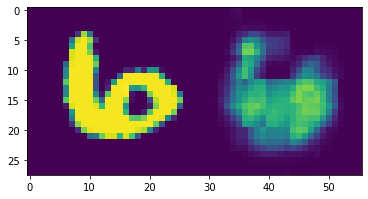

100%|███████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 74.65it/s, loss=0.0361]

Epoch: 2 	Training Loss: 2.428108


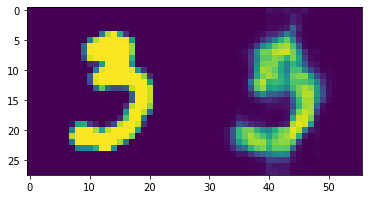

100%|███████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 75.87it/s, loss=0.0258]

Epoch: 3 	Training Loss: 1.905388


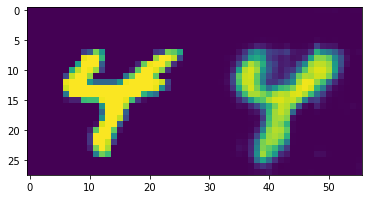

100%|███████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 74.54it/s, loss=0.0268]

Epoch: 4 	Training Loss: 1.647929


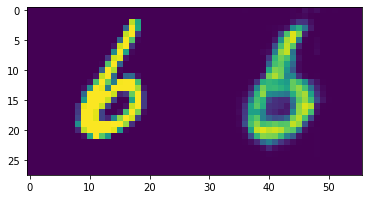

100%|███████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 74.17it/s, loss=0.0235]

Epoch: 5 	Training Loss: 1.507804


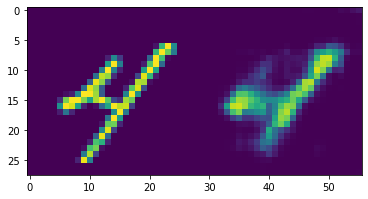

100%|███████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 74.25it/s, loss=0.0231]

Epoch: 6 	Training Loss: 1.417930


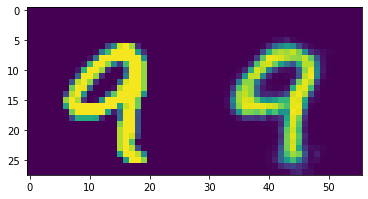

100%|███████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 74.18it/s, loss=0.0213]


Epoch: 7 	Training Loss: 1.349912


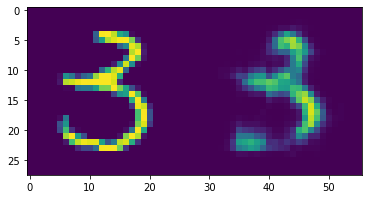

100%|███████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 73.85it/s, loss=0.0209]


Epoch: 8 	Training Loss: 1.296090


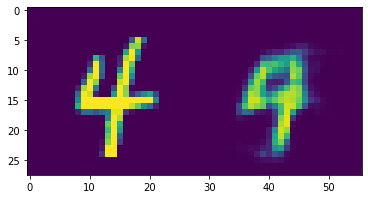

100%|███████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 75.82it/s, loss=0.0192]


Epoch: 9 	Training Loss: 1.255529


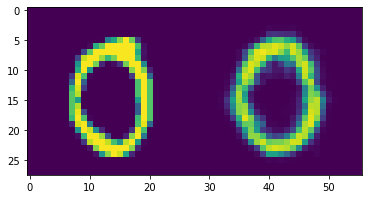

100%|███████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 74.14it/s, loss=0.0191]

Epoch: 10 	Training Loss: 1.224081


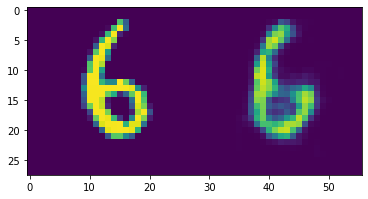

100%|███████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 74.04it/s, loss=0.0203]

Epoch: 11 	Training Loss: 1.192837


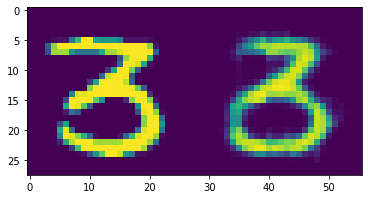

100%|█████████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 74.31it/s, loss=0.02]

Epoch: 12 	Training Loss: 1.168146


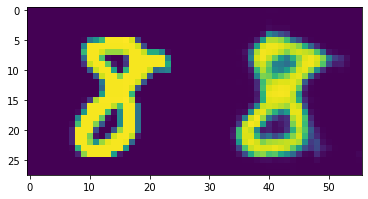

100%|███████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 73.26it/s, loss=0.0194]


Epoch: 13 	Training Loss: 1.145682


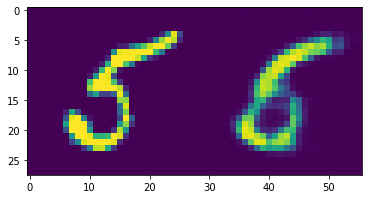

100%|███████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 72.45it/s, loss=0.0191]

Epoch: 14 	Training Loss: 1.126744


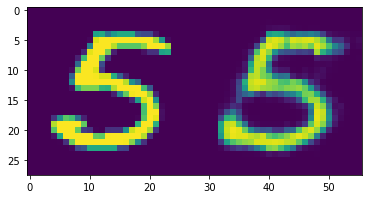

100%|███████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 76.07it/s, loss=0.0167]

Epoch: 15 	Training Loss: 1.108036


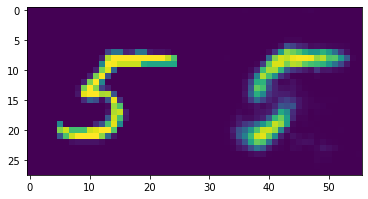

100%|███████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 77.32it/s, loss=0.0168]


Epoch: 16 	Training Loss: 1.087115


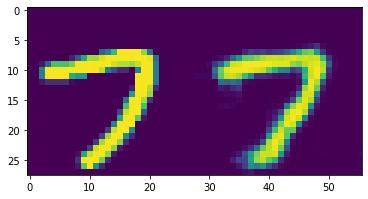

100%|███████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 76.28it/s, loss=0.0158]

Epoch: 17 	Training Loss: 1.073126


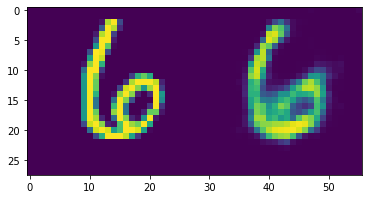

100%|███████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 77.54it/s, loss=0.0168]


Epoch: 18 	Training Loss: 1.058665


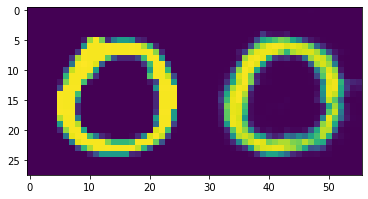

100%|████████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 77.39it/s, loss=0.017]

Epoch: 19 	Training Loss: 1.045284


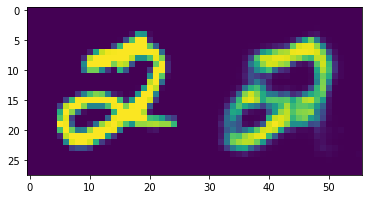

100%|███████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 77.87it/s, loss=0.0165]


Epoch: 20 	Training Loss: 1.034486


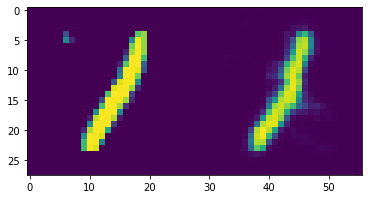

In [15]:
# number of epochs to train the model
n_epochs = 20

# for adding noise to images
noise_factor=0.5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    loop = tqdm(train_loader)
    ###################
    # train the model #
    ###################
    for data in loop:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        noisy_imgs = noisy_imgs.to('cuda')
        images = images.to('cuda')
        
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        with torch.cuda.amp.autocast():
            outputs = model(noisy_imgs)
            # calculate the loss
            # the "target" is still the original, not-noisy images
            loss = criterion(outputs, images)
            # backward pass: compute gradient of the loss with respect to model parameters
        
        
        # perform a single optimization step (parameter update)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # update running training loss
        train_loss += loss.item()*images.size(0)
        loop.set_postfix(loss=loss.item())
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))
    with torch.no_grad():
        model.eval()
        img = (images.cpu()[2].permute(1, 2, 0)+1)/2
        gen = (outputs.cpu()[2].permute(1, 2, 0)+1)/2
        img = np.concatenate((img, gen), axis=1)
        plt.imshow(img)
        plt.show()
        model.train()

In [47]:
img_list = []
with torch.no_grad():
    for i in range(10):
        img, _ = test_loader.dataset[np.random.randint(1000)]
        n_img = img + noise_factor*torch.randn(*img.shape)
        n_img = np.clip(n_img, 0., 1.)
        img_dn = model(n_img.to(device))
        img_dn = img_dn.to('cpu')
        
        combined_img = np.concatenate((img.permute(1, 2, 0), n_img.permute(1, 2, 0), img_dn.permute(1, 2, 0)), axis=1)
        img_list.append(combined_img)
        #plt.imshow(combined_img, cmap='gray')
        #plt.show()
        #plt.imshow(img.permute(1, 2, 0), cmap='gray')
        #plt.show()
        #plt.imshow(n_img.permute(1, 2, 0,), cmap='gray')
        #plt.show()
        #plt.imshow(img_dn.detach().permute(1, 2, 0), cmap='gray')
        #plt.show()
        
    #for i in img_list:
    #    plt.imshow(i)
    #    plt.show()

In [48]:

final = np.concatenate([i for i in img_list], axis=0)
    

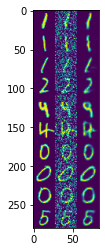

In [49]:
plt.imshow(final)

In [55]:
import cv2

cv2.imwrite('complete_image.png', complete_image*255)

True

In [50]:
final4 = final

In [53]:
img = [final1, final2, final3, final4]
complete_image = np.concatenate([i for i in img], axis=1)
print(np.shape(complete_image))

(280, 336, 1)


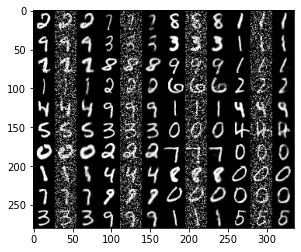

In [54]:
plt.imshow(complete_image, cmap='gray')